In [2]:
import pandas as pd
df = pd.read_csv('data.csv') # data is computer-generated by ChatGPT under the following assumptions:
    # most kernels pop between 60-75 seconds
    ## some pop earlier ~30-60 seconds 
    ### some pop late ~75-120 seconds
print(df.head())  # prints first 5 rows


   kernel  pop_time_seconds
0       1              62.3
1       2              58.7
2       3              74.1
3       4              67.9
4       5              35.6


In [3]:
import numpy as np
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

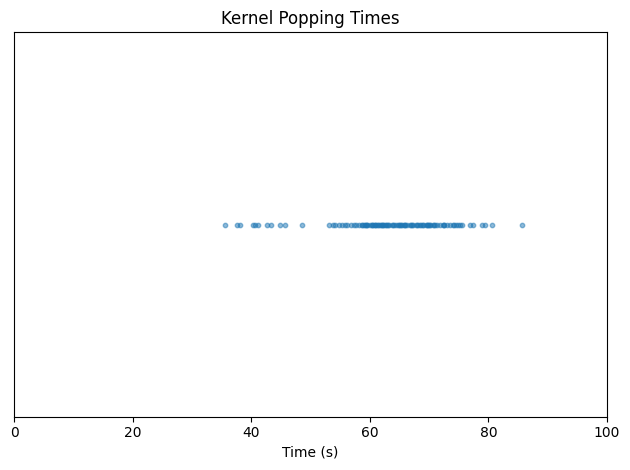

In [4]:
## Kernel Popping Times
pop_times = np.sort(df["pop_time_seconds"].values)
plt.scatter(pop_times, [1]*len(pop_times), s = 10, alpha= 0.5)
plt.xlabel("Time (s)")
plt.yticks([])
plt.title("Kernel Popping Times")
plt.xlim((0,100))
plt.tight_layout()
plt.show

In [5]:
inter_pop = np.diff(pop_times) # interpopping waiting times 
np.max(pop_times)
time = np.arange(0,100.1,0.1)
pops = []
count = 0 

# Cumulative Distribution Function (CDF) of Popped Kernels
for t in time:
    s = sum(pops)
    if np.any(np.isclose(pop_times,t, atol = 0.05)):
        count += 1 
        pops.append(count)
    else:
        pops.append(count)

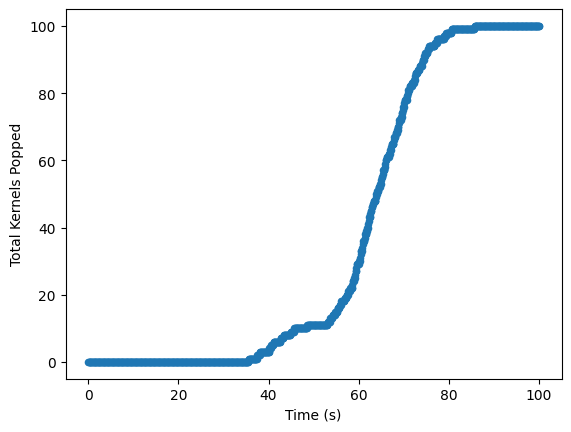

In [6]:
## Discrete Cumulutive Disitrubtion Function (CDF) of Popped Kernels 
plt.scatter(time,pops, s = 20)
plt.xlabel("Time (s)")
plt.ylabel("Total Kernels Popped")
plt.show()

The curve above clearly resembles the CDF of a Normal r.v. with some error due to intermediate popping clusters. To analyze the phases/regions of popping separately, we'll use the method of segmented regression with change of slope coefficients. In this method, under a suitable choice of $N$ regions, we fit the model:
\begin{equation*}
Y_{t} = \beta_{0} +\beta_{1}t+\beta_{2}(t−s_1)_{+} + \beta_{3}(t−s_2)_{+} + \ldots + \beta_{N}(t-s_{N-1})_{+} +\epsilon_{t}
\end{equation*}
with $\epsilon_{t} \overset{\mathrm{i.i.d.}}{\sim} N(0,\sigma^{2})$. The unknown parameters in this model are $\beta_{0}$, $\beta_{1}$,$\ldots$, $\beta_{N}$, $s_1$, $s_2$,$\ldots$, $s_{N-1}$, $\sigma$.  

Let $\{X^N(t)\}_{t \geq 0}$ denote a sequence of right-continuous, or càdlàg, piecewise time-homogeneous Poisson processes defined on all $t \in [0,T]$, where each process $X^N(t)$ is constructed with $N$ segments such that on the interval $[t_i, t_{i+1})$, the rate is constant and given by $\lambda_i$. Thus, the associated Poisson counting process is defined by:
 $$ 
 X^N(t + \Delta{t_i}) - X^N(t) \sim \textit{Poisson}(\lambda_{i}\cdot\Delta{t_i})
 $$ 

Assume that for a given deterministic, continuous function $\lambda : [0,T] \to \mathbb{R}_{\geq 0}$, the piecewise constant rates satisfy:
$$
\sup_{t \in [t_i, t_{i+1})} |\lambda_i - \lambda(t)| \to 0 \quad \text{as } N \to \infty
$$
Then the processes $\{X^N(t)\}_{t \geq 0}$ converge in distribution to a single time-inhomogeneous Poisson process $X(t)$ with time-varying intensity $\lambda(t)$ on all $t \in[0,T]$ $\textit{s.t.}$
$
X^N(\cdot) \xrightarrow{d} X(\cdot)$. The limiting process $X(t)$ when $N \rightarrow \infty$ satisfies:
$$
\mathbb{P}(X(t + h) - X(t) = k) = \frac{[\Lambda(t + h) - \Lambda(t)]^k}{k!} \exp\left(-[\Lambda(t + h) - \Lambda(t)]\right), \quad k \in \mathbb{N}
$$
where $\Lambda(t) = \int_0^t \lambda(s) \, ds$ is the cumulative intensity function. Therefore, we can finally conclude:
$$ 
\mathbb{P}(X(t + \Delta{t}) - X(t) = k) = \frac{[\lambda(t)\Delta{t}]^k}{k!} e^{-\lambda(t)\Delta{t}}
$$
Note that we cannot say that $X(t)$ is simply distributed as Poisson with rate $\lambda(t)$ but require the nuance of the cumulative intensity function, $\Lambda(t)$.

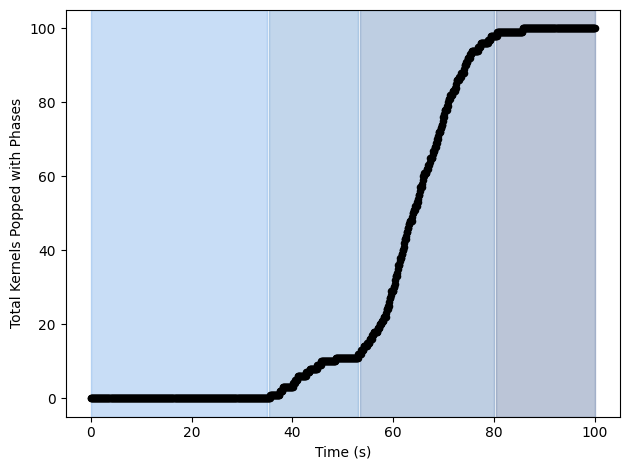

In [36]:
## Discrete Cumulutive Disitrubtion Function (CDF) of Popped Kernels with Shading
shaded_regions = [(0, 35),(35.3, 53),(53.4, 80),(80.3, 100)]
colors = ['#4a90e2', '#357ABD', '#2a5d9f', '#1e3f7d']
for (start, end), color in zip(shaded_regions, colors):
    plt.axvspan(start, end, color=color, alpha=0.3)

plt.scatter(time,pops, s = 20, color = "black")
plt.xlabel("Time (s)")
plt.ylabel("Total Kernels Popped with Phases")
plt.tight_layout()
plt.show()

We can first use a simple nonparametric regression on the CDF of kernels popped using a smoothing spline determined by Generalized Cross-Validation (GSV). First, we will fit $\hat{\Lambda}(t) \sim \textit{spline}(t)$. Then, we differentiate the time-continuous estimation to estimate $\lambda(t)$. 

In [7]:
import statsmodels.api as sm
from scipy.stats import t
import scipy.stats as stats
from itertools import combinations

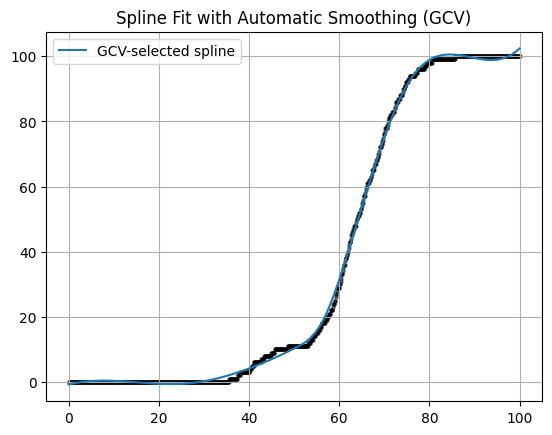

In [35]:
# non-parametric regression on cumulative counts using a smoothing spline
from scipy.interpolate import UnivariateSpline

# Automatic s selection using Generalized Cross-Validation (GCV)
spline = UnivariateSpline(time, pops)  # s=None by default
plt.plot(time, spline(time), label='GCV-selected spline')
plt.scatter(time, pops, s=5, color='k', alpha=0.5)
plt.title("Spline Fit with Automatic Smoothing (GCV)")
plt.legend()
plt.grid(True)
plt.show()


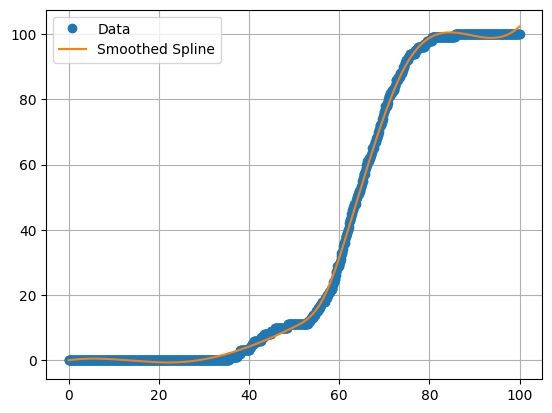

In [42]:
x = np.insert(time, 0, 0.0)
y = np.insert(pops, 0, 0.0)
w = np.ones_like(x)
w[0] = 1000  # ensures (0,0) intercept of spline 

# Fit spline
spline = UnivariateSpline(x, y, w=w)

# Evaluate spline
t_dense = np.linspace(0, x[-1], 500)
plt.plot(x, y, 'o', label='Data')
plt.plot(t_dense, spline(t_dense), label='Smoothed Spline')
plt.legend()
plt.grid(True)
plt.show()

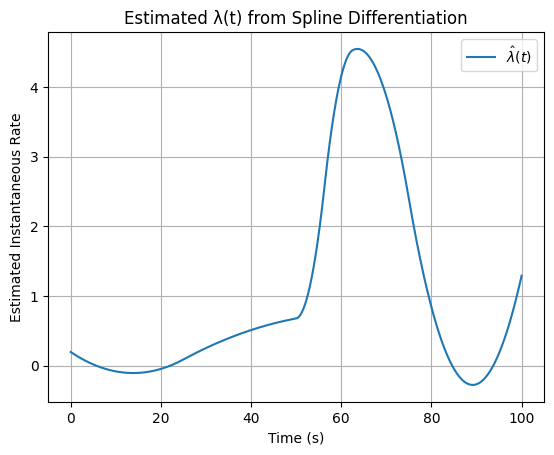

In [43]:
# estimation of lambda(t) via non-parametric regression
Lambda_hat = spline(time)
lambda_hat = spline.derivative()(time) # differentiate Lambda(t) to get lambda(t)

plt.plot(time, lambda_hat, label=r'$\hat{\lambda}(t)$')
plt.xlabel("Time (s)")
plt.ylabel("Estimated Instantaneous Rate")
plt.title("Estimated λ(t) from Spline Differentiation")
plt.grid()
plt.legend()
plt.show()

Alternatively, we can use Bayesian inference on small intervals of data modeled by: 
$$
Y_i \sim \textit{Poisson}(\lambda_i\cdot\Delta{t})
$$

Now that we have determined an approximate time-varying $\lambda(t)$, we can use the conjugate prior of Poisson, the Gamma distribution to smooth our estimated function of $\lambda(t)$. Essentially, at each time $t$, $\lambda(t) \sim \textit{Gamma}(\alpha(t), \beta(t))$. 

In [ ]:
import pymc as pm

# Discretize time into bins of size dt = 0.5
dt = 0.5
bins = np.arange(0, max(time) + dt, dt)
counts, _ = np.histogram(pop_times, bins=bins)

with pm.Model() as model:
    lambda_ = pm.Gamma("lambda", alpha=2, beta=1, shape=len(counts))
    y = pm.Poisson("y", mu=lambda_ * dt, observed=counts)

    trace = pm.sample(1000, tune=1000, target_accept=0.9)

# Posterior mean estimate of lambda(t)
lambda_mean = trace.posterior["lambda"].mean(dim=["chain", "draw"])

midpoints = (bins[:-1] + bins[1:]) / 2
plt.plot(midpoints, lambda_mean, label=r'$\mathbb{E}[\lambda(t)]$')
plt.xlabel("Time (s)")
plt.ylabel("Estimated Rate")
plt.title("Bayesian Estimate of Time-Varying Rate")
plt.grid()
plt.legend()
plt.show()